In [167]:
# Import necessary libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch.nn import Linear, Dropout
import torch.nn.functional as F
import torch.optim as optim
from torch_geometric.data import Data, DataLoader
import torch_geometric as T
from torch_geometric.data.data import BaseData, Data
from torch_geometric.utils import from_networkx
from torch_geometric.utils import dense_to_sparse
from torch_geometric.nn import GCNConv, SAGEConv, GraphConv, global_mean_pool
from torch.nn.utils import clip_grad_norm_

import networkx as nx

from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.preprocessing import StandardScaler

from itertools import product
import random

In [ ]:
# Read from csv without second list in daughter columns
training_df = pd.read_csv('train_data.csv')
testing_df = pd.read_csv('test_data.csv')

In [3]:
# Columns including daughter kinematics
train_d_cols = list(training_df[training_df.columns[training_df.columns.str.contains("_Daughters")]])
test_d_cols = list(testing_df[testing_df.columns[testing_df.columns.str.contains("_Daughters")]])

# Features columns (daughter kinematics + Eta and pT)
train_f_cols = train_d_cols + ['Jet0_Eta', 'Jet0_PT']
test_f_cols = test_d_cols + ['Jet1_Eta', 'Jet1_PT']

In [4]:
# Duplicate Jet PT and Eta elements as a list the same length as the number of daughters in each row
def duplicate(df, cols, n_col):
    def duplicate_value(row, col, n_col):
        value = row[col]
        if isinstance(value, (float, int)):
            num_daughters = row[n_col]
            return [value] * num_daughters
        return value

    for col in cols:
        df[col] = df.apply(lambda row: duplicate_value(row, col, n_col), axis=1)
    return df

# Converts string into list of floats (already duplicated and dropped second array)
def convert_to_lists(df, d_cols):
    for col in d_cols:
        df[col] = df[col].apply(lambda x: [float(num) for num in x.strip('[]').split(',')] if isinstance(x, str) else x)
    return df

In [5]:
# Duplicate and preprocess daughter columns
df = duplicate(training_df, ['Jet0_PT', 'Jet0_Eta', 'IsB'], 'Jet0_nDaughters')
df2 = duplicate(testing_df, ['Jet1_PT', 'Jet1_Eta', 'IsB'], 'Jet1_nDaughters')

# Clean up data from str to list of floats
df = convert_to_lists(df, train_d_cols)
df2 = convert_to_lists(df2, test_d_cols)

In [447]:
cut_df = pd.concat([df.head(800), df.iloc[100000:100800]]) 
cut_df2 = pd.concat([df2.head(200), df2.iloc[100000:100200]])

In [448]:
# Gets node features to create x tensor
def node_features(df, features_cols):
    node_features_list = []
    node_features = []
    for i, row in df.iterrows():
        row_nodes = []
        for col in features_cols:
            feature = df.at[i, col]
            if isinstance(feature, list):
                node_features.extend(feature)
                if len(row_nodes) < len(feature):
                    row_nodes.extend([[] for _ in range(len(feature) - len(row_nodes))])
                for j, val in enumerate(feature):
                    row_nodes[j].append(val)
            else:
                node_features.append(feature)
                for node in row_nodes:
                        node.append(feature)
        node_features_list.extend(row_nodes)
    return node_features_list

def create_data_object(df, features_cols):
    data_list = []

    for i in range(len(df)):
        node_df = df.iloc[[i]]
        
        features = node_features(node_df, features_cols)
        num_nodes = len(features)

        G = nx.complete_graph(num_nodes)
        edge_index = torch.tensor(list(G.edges)).t().contiguous()

        x = torch.tensor(features, dtype=torch.float)
        y = torch.tensor(node_df['IsB'].iloc[0], dtype=torch.long)
        train_mask = torch.ones(num_nodes, dtype=torch.bool)
        test_mask = torch.ones(num_nodes, dtype=torch.bool)

        data = Data(x=x, edge_index=edge_index, y=y, train_mask=train_mask, test_mask=test_mask)
        data_list.append(data)
        
    return data_list

In [449]:
train_data = create_data_object(cut_df, train_f_cols)
test_data = create_data_object(cut_df2, test_f_cols)

In [450]:
# Load data
train_loader = DataLoader(train_data, batch_size=1, shuffle=True)
test_loader = DataLoader(test_data, batch_size=1, shuffle=False)

# Training Model

In [463]:
# Define GNN model

class GNN(torch.nn.Module):
    def __init__(self):
        super(GNN, self).__init__()
        hidden_channels = 64
        self.conv1 = GraphConv(len(train_f_cols), hidden_channels)
        self.conv2 = GraphConv(hidden_channels, hidden_channels)
        self.conv3 = GraphConv(hidden_channels, hidden_channels)
        self.conv4 = GraphConv(hidden_channels, hidden_channels)
        self.lin = Linear(hidden_channels, 2)
        

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch

        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = self.conv3(x, edge_index)
        x = F.relu(x)
        x = self.conv4(x, edge_index)
        x = F.sigmoid(x)
        x = self.lin(x)
        return x
            
model = GNN()

In [473]:
# Define optimizer and criterion
optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)
criterion = torch.nn.CrossEntropyLoss()

# Training loop
def train():
    model.train()
    for data in train_loader:
        optimizer.zero_grad()
        out = model(data)
        loss = criterion(out[data.train_mask], data.y[data.train_mask])
        loss.backward()
        clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
    return loss.item()

def test():
    model.eval()
    total_correct = 0
    total_samples = 0
    
    with torch.no_grad():
        for data in test_loader:
            out = model(data)
            _, pred = out.max(dim=1)
            correct = pred[data.test_mask].eq(data.y[data.test_mask]).sum().item()
            total_correct += correct
            total_samples += data.test_mask.sum().item()

    accuracy = total_correct / total_samples
    return accuracy

for epoch in range(2):
    loss = train()
    acc = test()

    print(f'Epoch: {epoch + 1}, Loss: {loss:.4f}, Accuracy: {acc:.4f}')

Epoch: 1, Loss: 0.2357, Accuracy: 0.4800
Epoch: 2, Loss: 0.2201, Accuracy: 0.4800


# ROC Curve and AUC

In [388]:
y_true = [] # class values (0 or 1)
y_scores = [] # predicted probabilities

model.eval()
with torch.no_grad():
    for data in test_loader:
        out = model(data)
        _, pred = out.max(dim=1)
        y_true.append(data.y.numpy().flatten())
        y_scores.append(out[:, 1].detach().numpy())

y_true = np.concatenate(y_true)
y_scores = np.concatenate(y_scores)

In [389]:
# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_true, y_scores)
auc = roc_auc_score(y_true, y_scores)

In [390]:
# Compute background rejection and signal efficiency
back_rej = 1 - fpr
sig_eff = tpr

print(f'Background Rejection: {back_rej}')
print(f'Signal Efficiency: {sig_eff}')
print(f'AUC: {auc}')

Background Rejection: [1.         0.99933775 0.99801325 ... 0.00198675 0.         0.        ]
Signal Efficiency: [0.         0.         0.         ... 0.99927954 0.99927954 1.        ]
AUC: 0.49068672824780046


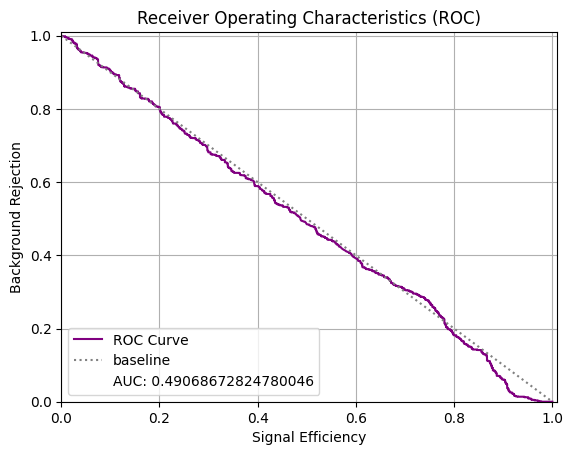

In [391]:
# Plot ROC Curve and show AUC
plt.plot(back_rej, sig_eff, label='ROC Curve', color='purple')
plt.plot([0, 1], [1, 0], color='grey', linestyle='dotted', label='baseline')
plt.plot([], [], ' ', label=f'AUC: {auc}')
plt.xlim([0.0, 1.01])
plt.ylim([0.0, 1.01])
plt.ylabel('Background Rejection')
plt.xlabel('Signal Efficiency' )
plt.title('Receiver Operating Characteristics (ROC)')
plt.legend(loc='lower left')
plt.grid(True)
plt.show()